# 🌍 Environmental Data Extraction Tutorial

This notebook demonstrates how to use EnvXtract to extract and analyze environmental data from raster files using both administrative regions (NUTS) and point locations.

## Overview

We'll cover:
1. Setting up the environment
2. Loading and inspecting input data
3. Extracting data for NUTS regions
4. Extracting data for point locations
5. Visualizing and analyzing results

> **Note**: This notebook requires the following Python packages:
> - envxtract
> - pandas
> - geopandas
> - matplotlib
> - seaborn
> - folium

In [1]:
import os
import glob
from pathlib import Path
from datetime import datetime

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

# Import the main extraction class
from envxtract.raster_extractor import RasterExtractor

# Set up plotting
plt.style.use('seaborn-v0_8')
%matplotlib inline

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 1. Configure Input/Output Paths

First, let's set up our data paths and check if all required files exist.

In [2]:
# Input data paths
RASTER_DIR = "../../data/input/rasters"
NUTS_FILE = "../../data/input/NUTS_RG_L3.shp"
POINTS_FILE = "../../data/input/combined_selected_ALL-points.geojson"

# Output directory
OUTPUT_DIR = "../../data/output"

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Raster file pattern
RASTER_PATTERN = "*.tif"  # All TIF files

# Find raster files
raster_files = glob.glob(os.path.join(RASTER_DIR, RASTER_PATTERN))

# Display available files
print("📁 Found Raster Files:")
if raster_files:
    for f in raster_files:
        print(f"   - {os.path.basename(f)}")
else:
    print("   No raster files found!")

print("\n🗺️ Boundary Files:")
print(f"   - NUTS: {'✅' if os.path.exists(NUTS_FILE) else '❌'} {os.path.basename(NUTS_FILE)}")
print(f"   - Points: {'✅' if os.path.exists(POINTS_FILE) else '❌'} {os.path.basename(POINTS_FILE)}")

📁 Found Raster Files:
   - PM10_elapse_additive.tif
   - pm10_mean_2010_CFadv.tif

🗺️ Boundary Files:
   - NUTS: ✅ NUTS_RG_L3.shp
   - Points: ✅ combined_selected_ALL-points.geojson


## 2. Inspect Input Data

Let's take a look at our input data to better understand what we're working with.

In [3]:
# Load and display NUTS boundaries
if os.path.exists(NUTS_FILE):
    nuts_gdf = gpd.read_file(NUTS_FILE)
    
    print("NUTS Data Summary:")
    print(f"Number of regions: {len(nuts_gdf)}")
    print(f"CRS: {nuts_gdf.crs}")
    print("\nColumns:")
    for col in nuts_gdf.columns:
        print(f"   - {col}")
    
    print("\nFirst few rows:")
    display(nuts_gdf.head())
    
    # Create a simple map
    m = folium.Map(location=[54, 15], zoom_start=4)
    
    # Add NUTS regions to map
    folium.GeoJson(
        nuts_gdf,
        style_function=lambda x: {
            'fillColor': '#3186cc',
            'color': '#000000',
            'weight': 1,
            'fillOpacity': 0.2
        },
        tooltip=folium.GeoJsonTooltip(fields=['NUTS_ID', 'NUTS_NAME'], aliases=['ID:', 'Name:'])
    ).add_to(m)
    
    display(m)
else:
    print("❌ NUTS file not found!")

NUTS Data Summary:
Number of regions: 1330
CRS: EPSG:4326

Columns:
   - NUTS_ID
   - LEVL_CODE
   - CNTR_CODE
   - NAME_LATN
   - NUTS_NAME
   - MOUNT_TYPE
   - URBN_TYPE
   - COAST_TYPE
   - Shape_Leng
   - Shape_Area
   - geometry

First few rows:


NUTS_ID  LEVL_CODE CNTR_CODE                 NAME_LATN  \
0   AT225          3        AT   West- und Südsteiermark   
1   AT226          3        AT  Westliche Obersteiermark   
2   AT311          3        AT                Innviertel   
3   AT312          3        AT                 Linz-Wels   
4   AT313          3        AT               Mühlviertel   

                  NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE  Shape_Leng  \
0   West- und Südsteiermark           0          0           0    2.974314   
1  Westliche Obersteiermark           0          0           0    3.455219   
2                Innviertel           0          0           0    3.325353   
3                 Linz-Wels           0          0           0    2.793845   
4               Mühlviertel           0          0           0    3.827477   

   Shape_Area                                           geometry  
0    0.271048  POLYGON ((14.84206 47.04861, 14.85731 47.04766...  
1    0.364538  POLYGON ((13.86437 47.25169, 13.90315 47.25805...  
2    0.341831  POLYGON ((13.5135 48.59096, 13.52832 48.58654,...  
3    0.210476  POLYGON ((13.98561 48.00269, 13.9468 48.02889,...  
4    0.323839  POLYGON ((13.86835 48.42631, 13.77426 48.47221...

In [4]:
# Load and display points
if os.path.exists(POINTS_FILE):
    points_gdf = gpd.read_file(POINTS_FILE)
    
    print("Points Data Summary:")
    print(f"Number of points: {len(points_gdf)}")
    print(f"CRS: {points_gdf.crs}")
    print("\nColumns:")
    for col in points_gdf.columns:
        print(f"   - {col}")
    
    print("\nFirst few rows:")
    display(points_gdf.head())
    
    # Create a map with points
    m_points = folium.Map(location=[54, 15], zoom_start=4)
    
    # Add points to map
    for idx, row in points_gdf.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=3,
            color='red',
            fill=True,
            popup=f"Point {idx}",
            tooltip=f"Coordinates: {row.geometry.x:.2f}, {row.geometry.y:.2f}"
        ).add_to(m_points)
    
    display(m_points)
else:
    print("❌ Points file not found!")

Points Data Summary:
Number of points: 250
CRS: EPSG:4326

Columns:
   - Name
   - geometry

First few rows:


Name                  geometry
0  BEL_Aalter_1  POINT (3.45978 51.05024)
1  BEL_Aalter_2   POINT (3.43805 51.1018)
2  BEL_Aalter_3  POINT (3.49154 51.10361)
3  BEL_Aalter_4  POINT (3.45846 51.10385)
4  BEL_Aalter_5  POINT (3.49428 51.03148)

## 3. Extract Data for NUTS Regions

Now let's extract environmental data for the NUTS regions. We'll use comprehensive statistics to get a full picture of the data distribution.

In [5]:
# Configure extraction for NUTS regions
if os.path.exists(NUTS_FILE) and raster_files:
    nuts_config = {
        "raster_files": raster_files,
        "boundary_files": [NUTS_FILE],
        "output_dir": os.path.join(OUTPUT_DIR, "nuts_results"),
        "output_prefix": "nuts_extraction",
        
        # Extract comprehensive statistics
        "statistics": {
            "basic": ["mean", "median", "min", "max", "std", "count"],
            "percentiles": [25, 75, 90, 95]
        },
        
        # Process only polygons
        "process_polygons": True,
        "process_points": False,
        
        # Output options
        "save_csv": True,
        "save_geojson": True,
        "use_raster_names_in_columns": True,
        
        # Minimum coverage requirement
        "min_coverage_percent": 10.0,
        
        "log_level": "INFO"
    }
    
    print("🚀 Starting NUTS extraction...")
    
    # Run extraction
    processor = RasterExtractor(config_dict=nuts_config)
    nuts_results = processor.run()
    
    if nuts_results['results'] is not None:
        print(f"✅ NUTS extraction completed!")
        print(f"📊 Results shape: {nuts_results['results'].shape}")
        print(f"📁 Files saved to: {nuts_results['export_paths']}")
        
        # Display first few results
        display(nuts_results['results'].head())
    else:
        print("❌ NUTS extraction failed")
else:
    print("⚠️ Skipping NUTS extraction - missing files")

2025-06-05 18:13:57,100 - INFO - Starting raster extraction process
2025-06-05 18:13:57,151 - INFO - Processing: PM10_elapse_additive.tif x NUTS_RG_L3.shp
2025-06-05 18:13:57,151 - INFO - Processing: PM10_elapse_additive.tif x NUTS_RG_L3.shp


🚀 Starting NUTS extraction...


2025-06-05 18:13:57,886 - INFO - Using ID field: NUTS_ID, Name field: NAME_LATN
2025-06-05 18:13:58,905 - INFO - Reprojecting geometries from EPSG:4326 to IGNF:ETRS89LAEA
2025-06-05 18:13:58,905 - INFO - Reprojecting geometries from EPSG:4326 to IGNF:ETRS89LAEA
2025-06-05 18:14:01,028 - INFO - Processing polygon 100/1330
2025-06-05 18:14:01,028 - INFO - Processing polygon 100/1330
2025-06-05 18:14:02,516 - INFO - Processing polygon 200/1330
2025-06-05 18:14:02,516 - INFO - Processing polygon 200/1330
2025-06-05 18:14:03,895 - INFO - Processing polygon 300/1330
2025-06-05 18:14:03,895 - INFO - Processing polygon 300/1330
2025-06-05 18:14:05,167 - INFO - Processing polygon 400/1330
2025-06-05 18:14:05,167 - INFO - Processing polygon 400/1330
2025-06-05 18:14:06,551 - INFO - Processing polygon 500/1330
2025-06-05 18:14:06,551 - INFO - Processing polygon 500/1330
2025-06-05 18:14:08,016 - INFO - Processing polygon 600/1330
2025-06-05 18:14:08,016 - INFO - Processing polygon 600/1330
2025-0

✅ NUTS extraction completed!
📊 Results shape: (1330, 24)
📁 Files saved to: ['../../data/output/nuts_results/extraction_results_20250605_181445.csv', '../../data/output/nuts_results/extraction_metadata_20250605_181445.json']


NUTS_ID  PM10_elapse_additive_mean  PM10_elapse_additive_median  \
0   AL011                        NaN                          NaN   
1   AL012                        NaN                          NaN   
2   AL013                        NaN                          NaN   
3   AL014                        NaN                          NaN   
4   AL015                        NaN                          NaN   

   PM10_elapse_additive_min  PM10_elapse_additive_max  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   PM10_elapse_additive_std  PM10_elapse_additive_count  \
0                       NaN                         NaN   
1                       NaN                         NaN   
2                       NaN                         NaN   
3                       NaN                         NaN   
4                       NaN                         NaN   

   PM10_elapse_additive_p25  PM10_elapse_additive_p75  \
0                       NaN                       NaN   
1                       NaN                       NaN   
2                       NaN                       NaN   
3                       NaN                       NaN   
4                       NaN                       NaN   

   PM10_elapse_additive_p90  ...  pm10_mean_2010_CFadv_median  \
0                       NaN  ...                    15.392899   
1                       NaN  ...                    20.220791   
2                       NaN  ...                    15.829900   
3                       NaN  ...                    18.225130   
4                       NaN  ...                    15.758139   

   pm10_mean_2010_CFadv_min pm10_mean_2010_CFadv_max  \
0                 10.918492                24.657339   
1                 13.832294                22.911085   
2                  9.031151                25.480545   
3                 12.632630                23.071295   
4                  9.453502                22.483017   

   pm10_mean_2010_CFadv_std  pm10_mean_2010_CFadv_count  \
0                  3.078381                      2642.0   
1                  2.431462                       874.0   
2                  3.150738                      2572.0   
3                  2.327304                      1812.0   
4                  2.761629                      3742.0   

   pm10_mean_2010_CFadv_p25  pm10_mean_2010_CFadv_p75  \
0                 13.600963                 18.077131   
1                 17.281794                 21.845158   
2                 13.318596                 18.046051   
3                 16.259174                 19.305193   
4                 14.153191                 17.738255   

   pm10_mean_2010_CFadv_p90  pm10_mean_2010_CFadv_p95  NAME_LATN_y  
0                 20.114910                 22.990709        Dibër  
1                 22.274185                 22.494440       Durrës  
2                 19.161102                 19.942554        Kukës  
3                 20.992638                 22.143951        Lezhë  
4                 18.936750                 20.451447      Shkodër  

[5 rows x 24 columns]

## 4. Extract Data for Point Locations

Next, let's extract data for the monitoring station points. We'll use a buffer around each point to get representative values.

In [6]:
# Configure extraction for points
if os.path.exists(POINTS_FILE) and raster_files:
    points_config = {
        "raster_files": raster_files,
        "boundary_files": [POINTS_FILE],
        "output_dir": os.path.join(OUTPUT_DIR, "points_results"),
        "output_prefix": "points_extraction",
        
        # Extract mean values with some additional stats
        "statistics": {
            "basic": ["mean", "min", "max", "std"],
            "percentiles": [25, 75]
        },
        
        # Process only points
        "process_polygons": False,
        "process_points": True,
        
        # Point-specific options
        "buffer_distance": 1000.0,  # 1km buffer around points
        
        # Output options
        "save_csv": True,
        "save_geojson": True,
        "use_raster_names_in_columns": True,
        
        "log_level": "INFO"
    }
    
    print("🚀 Starting points extraction...")
    
    # Run extraction
    processor = RasterExtractor(config_dict=points_config)
    points_results = processor.run()
    
    if points_results['results'] is not None:
        print(f"✅ Points extraction completed!")
        print(f"📊 Results shape: {points_results['results'].shape}")
        print(f"📁 Files saved to: {points_results['export_paths']}")
        
        # Display first few results
        display(points_results['results'].head())
    else:
        print("❌ Points extraction failed")
else:
    print("⚠️ Skipping points extraction - missing files")

2025-06-05 18:14:45,844 - INFO - Starting raster extraction process
2025-06-05 18:14:45,910 - INFO - Processing: PM10_elapse_additive.tif x combined_selected_ALL-points.geojson
2025-06-05 18:14:45,910 - INFO - Processing: PM10_elapse_additive.tif x combined_selected_ALL-points.geojson
2025-06-05 18:14:45,972 - INFO - Using ID field: index, Name field: Name
2025-06-05 18:14:45,972 - INFO - Using ID field: index, Name field: Name


🚀 Starting points extraction...


2025-06-05 18:14:46,322 - INFO - Reprojecting geometries from EPSG:4326 to IGNF:ETRS89LAEA
2025-06-05 18:14:47,450 - INFO - Processing polygon 100/250
2025-06-05 18:14:47,450 - INFO - Processing polygon 100/250
2025-06-05 18:14:48,771 - INFO - Processing polygon 200/250
2025-06-05 18:14:48,771 - INFO - Processing polygon 200/250
2025-06-05 18:14:49,532 - INFO - Processing: pm10_mean_2010_CFadv.tif x combined_selected_ALL-points.geojson
2025-06-05 18:14:49,532 - INFO - Processing: pm10_mean_2010_CFadv.tif x combined_selected_ALL-points.geojson
2025-06-05 18:14:49,580 - INFO - Using ID field: index, Name field: Name
2025-06-05 18:14:49,580 - INFO - Using ID field: index, Name field: Name
2025-06-05 18:14:52,509 - INFO - Reprojecting geometries from EPSG:4326 to PROJCS["Lambert_Azimuthal_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["E

✅ Points extraction completed!
📊 Results shape: (250, 15)
📁 Files saved to: ['../../data/output/points_results/extraction_results_20250605_181455.csv', '../../data/output/points_results/extraction_metadata_20250605_181455.json']


index  PM10_elapse_additive_mean  PM10_elapse_additive_min  \
0      0                  25.769805                 25.027762   
1      1                  25.473364                 24.549883   
2      2                  24.787818                 24.514750   
3      3                  25.219556                 24.550798   
4      4                  25.200501                 24.991567   

   PM10_elapse_additive_max  PM10_elapse_additive_std  \
0                 27.401615                  0.808817   
1                 27.297127                  0.799052   
2                 25.219970                  0.304472   
3                 27.297127                  0.816380   
4                 25.951125                  0.314558   

   PM10_elapse_additive_p25  PM10_elapse_additive_p75  coverage_percent  \
0                 25.139126                 26.210390         88.888889   
1                 24.888554                 25.715227         88.888889   
2                 24.542401                 25.145313         88.888889   
3                 24.638077                 25.249493        100.000000   
4                 25.007741                 25.167576         77.777778   

           Name  pm10_mean_2010_CFadv_mean  pm10_mean_2010_CFadv_min  \
0  BEL_Aalter_1                  25.334839                 24.478685   
1  BEL_Aalter_2                  24.786783                 23.938591   
2  BEL_Aalter_3                  24.299540                 23.072460   
3  BEL_Aalter_4                  24.607983                 23.072460   
4  BEL_Aalter_5                  24.733425                 24.520409   

   pm10_mean_2010_CFadv_max  pm10_mean_2010_CFadv_std  \
0                 26.101561                  0.548160   
1                 25.771654                  0.640824   
2                 25.099518                  0.578710   
3                 25.771654                  0.821256   
4                 25.209692                  0.217658   

   pm10_mean_2010_CFadv_p25  pm10_mean_2010_CFadv_p75  
0                 25.042778                 25.627163  
1                 24.134344                 25.253265  
2                 24.132740                 24.522348  
3                 24.145729                 25.247505  
4                 24.585203                 24.753662

## 5. Analyze and Visualize Results

Let's load the latest results and create some visualizations to understand our extracted data.

In [7]:
# Function to get the latest file from a pattern
def get_latest_file(pattern):
    files = glob.glob(pattern)
    if not files:
        return None
    return max(files, key=os.path.getctime)

# Function to clip negative values from environmental data
def clip_negative_values(df, verbose=True):
    """Clip negative values in environmental data columns"""
    if df is None:
        return df
    
    df_cleaned = df.copy()
    clipped_cols = []
    
    # Find columns that contain environmental data (numerical columns excluding ID columns)
    env_cols = [col for col in df.columns if df[col].dtype.kind in 'fi' and 
                not col.lower().startswith(('id', 'name', 'geometry'))]
    
    for col in env_cols:
        if df[col].min() < 0:
            negative_count = (df[col] < 0).sum()
            df_cleaned[col] = df[col].clip(lower=0)
            clipped_cols.append((col, negative_count))
    
    if verbose and clipped_cols:
        print("🔧 Clipped negative values:")
        for col, count in clipped_cols:
            print(f"   - {col}: {count} negative values set to 0")
    
    return df_cleaned

# Load the latest results
nuts_file = get_latest_file(os.path.join(OUTPUT_DIR, "nuts_results", "*.csv"))
points_file = get_latest_file(os.path.join(OUTPUT_DIR, "points_results", "*.csv"))

# Load data if files exist
nuts_results_df = None
points_results_df = None

if nuts_file:
    nuts_results_df = pd.read_csv(nuts_file)
    nuts_results_df = clip_negative_values(nuts_results_df)
    print(f"✅ Loaded NUTS results: {nuts_results_df.shape}")
    print(f"   Columns: {list(nuts_results_df.columns)}")
else:
    print("⚠️ No NUTS results found")

if points_file:
    points_results_df = pd.read_csv(points_file)
    points_results_df = clip_negative_values(points_results_df)
    print(f"✅ Loaded points results: {points_results_df.shape}")
    print(f"   Columns: {list(points_results_df.columns)}")
else:
    print("⚠️ No points results found")

🔧 Clipped negative values:
   - PM10_elapse_additive_min: 14 negative values set to 0
✅ Loaded NUTS results: (1330, 24)
   Columns: ['NUTS_ID', 'PM10_elapse_additive_mean', 'PM10_elapse_additive_median', 'PM10_elapse_additive_min', 'PM10_elapse_additive_max', 'PM10_elapse_additive_std', 'PM10_elapse_additive_count', 'PM10_elapse_additive_p25', 'PM10_elapse_additive_p75', 'PM10_elapse_additive_p90', 'PM10_elapse_additive_p95', 'coverage_percent', 'NAME_LATN_x', 'pm10_mean_2010_CFadv_mean', 'pm10_mean_2010_CFadv_median', 'pm10_mean_2010_CFadv_min', 'pm10_mean_2010_CFadv_max', 'pm10_mean_2010_CFadv_std', 'pm10_mean_2010_CFadv_count', 'pm10_mean_2010_CFadv_p25', 'pm10_mean_2010_CFadv_p75', 'pm10_mean_2010_CFadv_p90', 'pm10_mean_2010_CFadv_p95', 'NAME_LATN_y']
✅ Loaded points results: (250, 15)
   Columns: ['index', 'PM10_elapse_additive_mean', 'PM10_elapse_additive_min', 'PM10_elapse_additive_max', 'PM10_elapse_additive_std', 'PM10_elapse_additive_p25', 'PM10_elapse_additive_p75', 'coverag

📊 Creating visualizations for 2 environmental variables...
   Note: Negative values have been clipped to 0


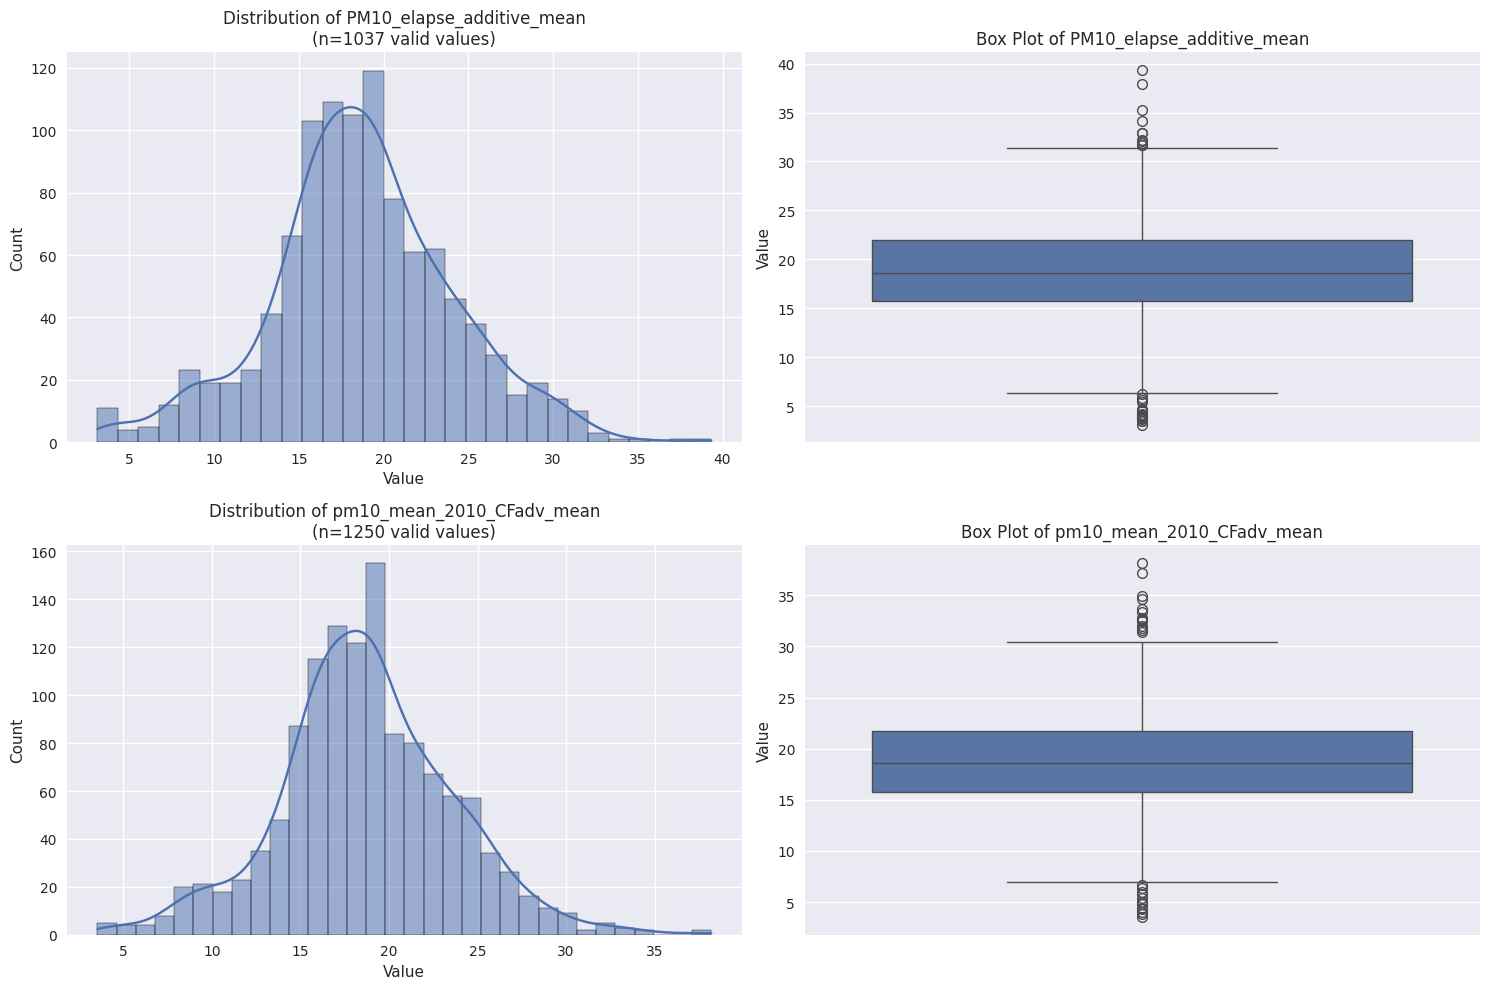


📈 Summary Statistics (after clipping):


PM10_elapse_additive_mean  pm10_mean_2010_CFadv_mean
count                1037.000000                1250.000000
mean                   18.725951                  18.705205
std                     5.429494                   4.901331
min                     3.119052                   3.537827
25%                    15.713702                  15.788623
50%                    18.617538                  18.570888
75%                    22.010180                  21.710085
max                    39.334643                  38.190781

In [8]:
# Create distribution visualizations
if nuts_results_df is not None:
    # Find environmental variable columns (those ending with statistics)
    env_columns = [col for col in nuts_results_df.columns if any(stat in col for stat in ['_mean', '_median', '_max'])]
    mean_columns = [col for col in env_columns if col.endswith('_mean')]
    
    if mean_columns:
        print(f"📊 Creating visualizations for {len(mean_columns)} environmental variables...")
        print(f"   Note: Negative values have been clipped to 0")
        
        # Create subplots for distribution analysis
        fig, axes = plt.subplots(len(mean_columns), 2, figsize=(15, 5*len(mean_columns)))
        if len(mean_columns) == 1:
            axes = axes.reshape(1, -1)
        
        for i, col in enumerate(mean_columns):
            # Check data validity
            valid_data = nuts_results_df[col].dropna()
            
            if len(valid_data) > 0:
                # Histogram with KDE
                sns.histplot(data=nuts_results_df, x=col, kde=True, ax=axes[i, 0])
                axes[i, 0].set_title(f'Distribution of {col}\n(n={len(valid_data)} valid values)')
                axes[i, 0].set_xlabel('Value')
                axes[i, 0].set_ylabel('Count')
                
                # Box plot
                sns.boxplot(data=nuts_results_df, y=col, ax=axes[i, 1])
                axes[i, 1].set_title(f'Box Plot of {col}')
                axes[i, 1].set_ylabel('Value')
            else:
                # Handle empty data
                axes[i, 0].text(0.5, 0.5, 'No valid data', transform=axes[i, 0].transAxes, ha='center')
                axes[i, 1].text(0.5, 0.5, 'No valid data', transform=axes[i, 1].transAxes, ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Summary statistics table
        print("\n📈 Summary Statistics (after clipping):")
        display(nuts_results_df[mean_columns].describe())
    else:
        print("No mean columns found for visualization")
else:
    print("No NUTS results available for visualization")

📊 Comparing 2 common variables between points and regions...
   Variables: PM10_elapse_additive, pm10_2010_CFadv


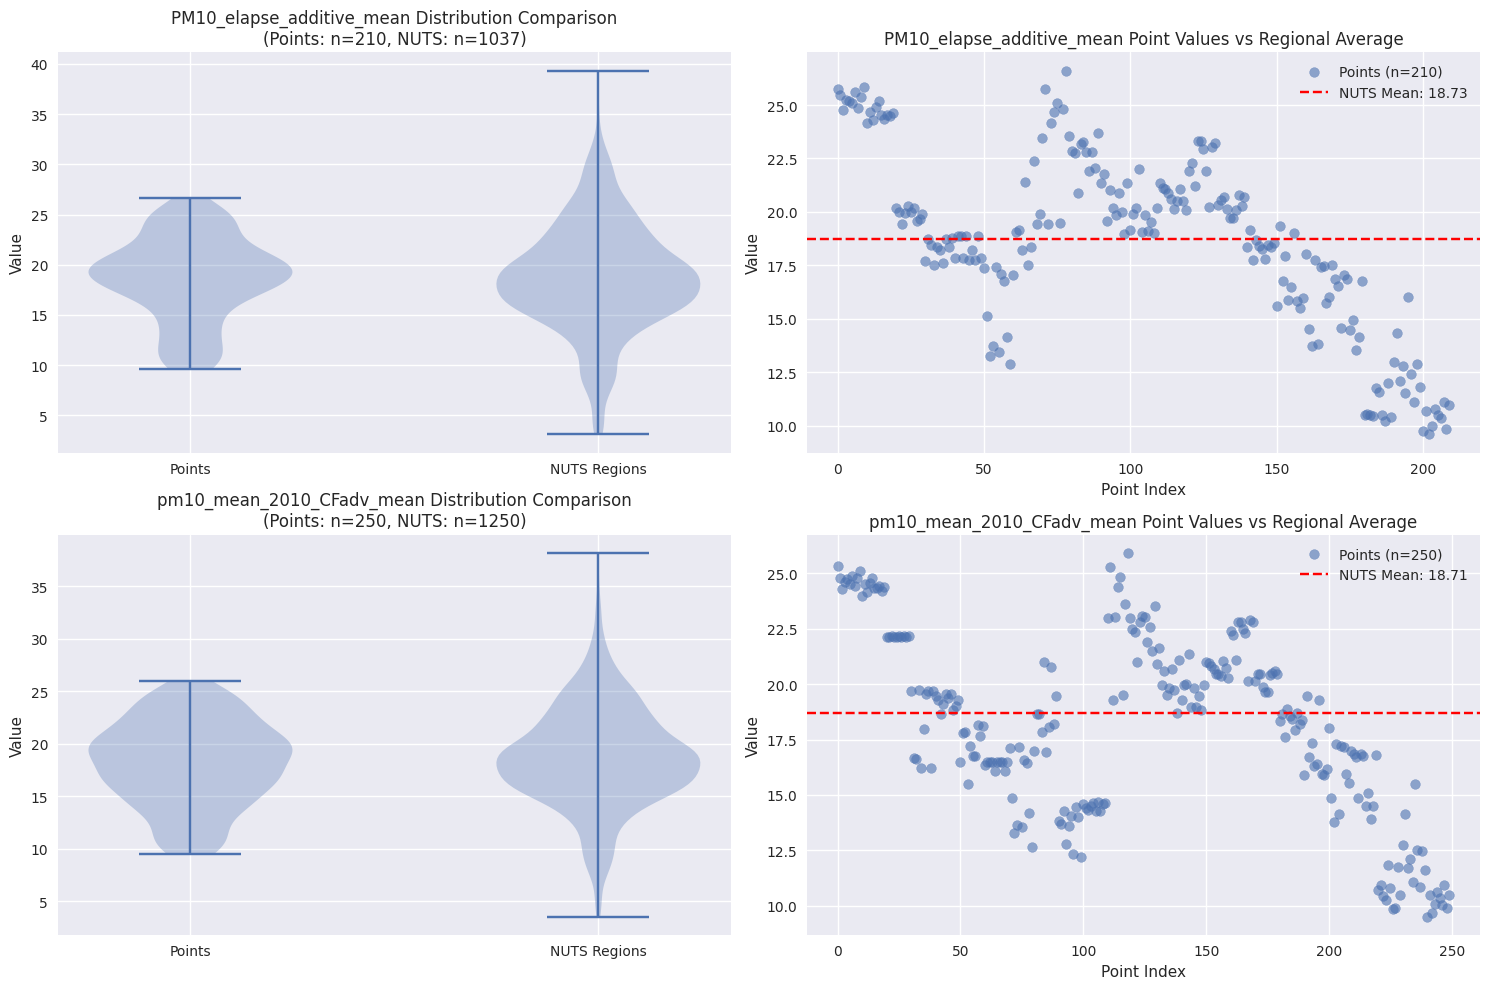

In [9]:
# Compare point values with regional statistics
if points_results_df is not None and nuts_results_df is not None:
    # Find common environmental variables
    points_mean_cols = [col for col in points_results_df.columns if col.endswith('_mean')]
    nuts_mean_cols = [col for col in nuts_results_df.columns if col.endswith('_mean')]
    common_vars = list(set(points_mean_cols) & set(nuts_mean_cols))
    
    print(f"📊 Comparing {len(common_vars)} common variables between points and regions...")
    print(f"   Variables: {', '.join([v.replace('_mean', '') for v in common_vars])}")
    
    if common_vars:
        fig, axes = plt.subplots(len(common_vars), 2, figsize=(15, 5*len(common_vars)))
        if len(common_vars) == 1:
            axes = axes.reshape(1, -1)
        
        for i, var in enumerate(common_vars):
            # Get valid data
            points_data = points_results_df[var].dropna()
            nuts_data = nuts_results_df[var].dropna()
            
            if len(points_data) > 0 and len(nuts_data) > 0:
                # Violin plot comparison
                data_to_plot = [points_data, nuts_data]
                parts = axes[i, 0].violinplot(data_to_plot, positions=[1, 2])
                axes[i, 0].set_xticks([1, 2])
                axes[i, 0].set_xticklabels(['Points', 'NUTS Regions'])
                axes[i, 0].set_title(f'{var} Distribution Comparison\n(Points: n={len(points_data)}, NUTS: n={len(nuts_data)})')
                axes[i, 0].set_ylabel('Value')
                
                # Scatter plot of point values
                axes[i, 1].scatter(range(len(points_data)), 
                                 points_data,
                                 alpha=0.6,
                                 label=f'Points (n={len(points_data)})')
                axes[i, 1].axhline(nuts_data.mean(), 
                                 color='red', 
                                 linestyle='--', 
                                 label=f'NUTS Mean: {nuts_data.mean():.2f}')
                axes[i, 1].set_xlabel('Point Index')
                axes[i, 1].set_ylabel('Value')
                axes[i, 1].set_title(f'{var} Point Values vs Regional Average')
                axes[i, 1].legend()
            else:
                axes[i, 0].text(0.5, 0.5, 'Insufficient data', transform=axes[i, 0].transAxes, ha='center')
                axes[i, 1].text(0.5, 0.5, 'Insufficient data', transform=axes[i, 1].transAxes, ha='center')
        
        plt.tight_layout()
        plt.show()
    else:
        print("No common variables found for comparison")
else:
    print("Need both points and NUTS results for comparison")

## 6. Create an Interactive Map

Finally, let's create an interactive map showing both NUTS regions and points, colored by one of our environmental variables.

## 6. Intelligent Scatter Plot Comparisons

Let's create intelligent scatter plots to compare different raster extraction results. We'll implement:
1. Variable-to-variable comparisons within datasets (e.g., PM10 vs Temperature within NUTS)
2. Same-variable comparisons between datasets (e.g., PM10 in NUTS vs PM10 in Points)
3. Multi-variable correlation analysis
4. Interactive selection of variables for comparison

In [10]:
# Intelligent scatter plot functionality
def get_variable_base_names(df):
    """Extract base variable names (without statistics suffixes)"""
    if df is None:
        return []
    
    # Find columns with statistics suffixes
    stat_cols = [col for col in df.columns if any(stat in col for stat in ['_mean', '_median', '_max', '_min', '_std'])]
    
    # Extract base names
    base_names = set()
    for col in stat_cols:
        for stat in ['_mean', '_median', '_max', '_min', '_std']:
            if col.endswith(stat):
                base_name = col[:-len(stat)]
                base_names.add(base_name)
                break
    
    return sorted(list(base_names))

def create_variable_pairs(variables, same_var_comparison=False):
    """Create intelligent variable pairs for comparison"""
    pairs = []
    
    if same_var_comparison:
        # For same variable comparison between datasets
        for var in variables:
            pairs.append((var, var))
    else:
        # For different variable comparisons within dataset
        for i, var1 in enumerate(variables):
            for var2 in variables[i+1:]:
                pairs.append((var1, var2))
    
    return pairs

def create_scatter_plot(df1, df2, var1, var2, stat='_mean', title_prefix='', 
                       dataset1_name='Dataset 1', dataset2_name='Dataset 2',
                       comparison_type='within'):
    """Create intelligent scatter plots with proper handling of data"""
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Prepare column names
    col1 = f"{var1}{stat}"
    col2 = f"{var2}{stat}"
    
    if comparison_type == 'within':
        # Within-dataset comparison (different variables)
        for i, (df, name) in enumerate([(df1, dataset1_name), (df2, dataset2_name)]):
            if df is not None and col1 in df.columns and col2 in df.columns:
                # Get valid data
                valid_mask = df[col1].notna() & df[col2].notna() & (df[col1] >= 0) & (df[col2] >= 0)
                x_data = df.loc[valid_mask, col1]
                y_data = df.loc[valid_mask, col2]
                
                if len(x_data) > 1:
                    # Create scatter plot
                    axes[i].scatter(x_data, y_data, alpha=0.6, s=50)
                    
                    # Add trend line if enough points
                    if len(x_data) > 2:
                        z = np.polyfit(x_data, y_data, 1)
                        p = np.poly1d(z)
                        x_trend = np.linspace(x_data.min(), x_data.max(), 100)
                        axes[i].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2)
                        
                        # Calculate correlation
                        corr = np.corrcoef(x_data, y_data)[0, 1]
                        axes[i].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[i].transAxes, 
                                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                    axes[i].set_xlabel(f'{var1.replace("_", " ").title()} {stat.replace("_", " ").title()}')
                    axes[i].set_ylabel(f'{var2.replace("_", " ").title()} {stat.replace("_", " ").title()}')
                    axes[i].set_title(f'{title_prefix}{name}\n({len(x_data)} valid points)')
                    axes[i].grid(True, alpha=0.3)
                else:
                    axes[i].text(0.5, 0.5, f'Insufficient data\n({len(x_data)} points)', 
                               transform=axes[i].transAxes, ha='center', va='center')
                    axes[i].set_title(f'{title_prefix}{name}\n(No valid data)')
            else:
                axes[i].text(0.5, 0.5, 'Data not available', 
                           transform=axes[i].transAxes, ha='center', va='center')
                axes[i].set_title(f'{title_prefix}{name}\n(No data)')
    
    elif comparison_type == 'between':
        # Between-dataset comparison (same variable)
        if df1 is not None and df2 is not None and col1 in df1.columns and col1 in df2.columns:
            # Get valid data from both datasets
            valid_data1 = df1[df1[col1].notna() & (df1[col1] >= 0)][col1]
            valid_data2 = df2[df2[col1].notna() & (df2[col1] >= 0)][col1]
            
            if len(valid_data1) > 0 and len(valid_data2) > 0:
                # Scatter plot comparing datasets
                min_len = min(len(valid_data1), len(valid_data2))
                x_data = valid_data1.iloc[:min_len].values
                y_data = valid_data2.iloc[:min_len].values
                
                axes[0].scatter(x_data, y_data, alpha=0.6, s=50)
                
                # Add 1:1 line
                min_val = min(x_data.min(), y_data.min())
                max_val = max(x_data.max(), y_data.max())
                axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='1:1 line')
                
                # Add trend line
                if len(x_data) > 2:
                    z = np.polyfit(x_data, y_data, 1)
                    p = np.poly1d(z)
                    x_trend = np.linspace(min_val, max_val, 100)
                    axes[0].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Trend line')
                    
                    # Calculate correlation
                    corr = np.corrcoef(x_data, y_data)[0, 1]
                    axes[0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0].transAxes, 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                axes[0].set_xlabel(f'{dataset1_name}: {var1.replace("_", " ").title()} {stat.replace("_", " ").title()}')
                axes[0].set_ylabel(f'{dataset2_name}: {var1.replace("_", " ").title()} {stat.replace("_", " ").title()}')
                axes[0].set_title(f'{title_prefix}Dataset Comparison: {var1.replace("_", " ").title()}\n({min_len} paired points)')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # Hide second subplot for between comparison
                axes[1].axis('off')
            else:
                axes[0].text(0.5, 0.5, 'Insufficient paired data', 
                           transform=axes[0].transAxes, ha='center', va='center')
                axes[1].axis('off')
        else:
            axes[0].text(0.5, 0.5, 'Data not available', 
                       transform=axes[0].transAxes, ha='center', va='center')
            axes[1].axis('off')
    
    plt.tight_layout()
    return fig

print("✅ Scatter plot functions defined successfully!")

✅ Scatter plot functions defined successfully!


🔍 Creating within-dataset variable comparisons...
   📊 NUTS variables: ['PM10_elapse_additive', 'pm10_mean_2010_CFadv']
   📍 Points variables: ['PM10_elapse_additive', 'pm10_mean_2010_CFadv']
   🔄 Found 2 common variables for comparison
   📈 Creating scatter plots for 1 variable pairs...

   📊 Pair 1/1: Pm10 Elapse Additive vs Pm10 Mean 2010 Cfadv


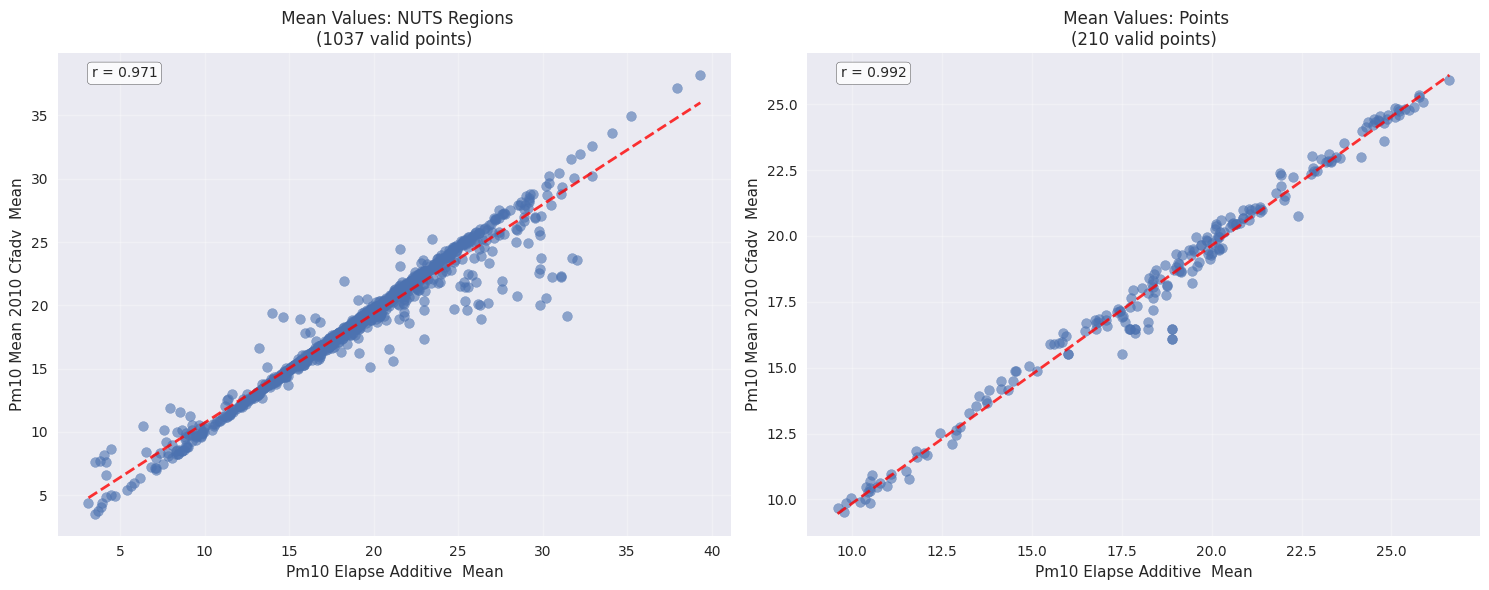

In [11]:
# Within-dataset comparisons: Different variables within same dataset
if nuts_results_df is not None or points_results_df is not None:
    print("🔍 Creating within-dataset variable comparisons...")
    
    # Get available variables for each dataset
    nuts_vars = get_variable_base_names(nuts_results_df) if nuts_results_df is not None else []
    points_vars = get_variable_base_names(points_results_df) if points_results_df is not None else []
    
    print(f"   📊 NUTS variables: {nuts_vars}")
    print(f"   📍 Points variables: {points_vars}")
    
    # Find common variables between datasets
    common_vars = list(set(nuts_vars) & set(points_vars))
    
    if len(common_vars) >= 2:
        print(f"   🔄 Found {len(common_vars)} common variables for comparison")
        
        # Create variable pairs for comparison
        var_pairs = create_variable_pairs(common_vars)
        
        # Limit to most interesting comparisons (max 6 pairs)
        max_pairs = min(6, len(var_pairs))
        selected_pairs = var_pairs[:max_pairs]
        
        print(f"   📈 Creating scatter plots for {len(selected_pairs)} variable pairs...")
        
        for i, (var1, var2) in enumerate(selected_pairs):
            print(f"\n   📊 Pair {i+1}/{len(selected_pairs)}: {var1.replace('_', ' ').title()} vs {var2.replace('_', ' ').title()}")
            
            # Try different statistics
            for stat in ['_mean', '_median']:
                if (nuts_results_df is not None and f"{var1}{stat}" in nuts_results_df.columns and f"{var2}{stat}" in nuts_results_df.columns) or \
                   (points_results_df is not None and f"{var1}{stat}" in points_results_df.columns and f"{var2}{stat}" in points_results_df.columns):
                    
                    fig = create_scatter_plot(
                        nuts_results_df, points_results_df, 
                        var1, var2, stat=stat,
                        title_prefix=f'{stat.replace("_", " ").title()} Values: ',
                        dataset1_name='NUTS Regions',
                        dataset2_name='Points',
                        comparison_type='within'
                    )
                    plt.show()
                    break  # Only show one statistic per pair to avoid overcrowding
    
    elif len(nuts_vars) >= 2:
        print(f"   📊 Creating NUTS-only comparisons ({len(nuts_vars)} variables)")
        var_pairs = create_variable_pairs(nuts_vars)[:3]  # Limit to 3 pairs
        
        for var1, var2 in var_pairs:
            fig = create_scatter_plot(
                nuts_results_df, None, 
                var1, var2, stat='_mean',
                title_prefix='NUTS Regions: ',
                dataset1_name='NUTS Regions',
                dataset2_name='N/A',
                comparison_type='within'
            )
            plt.show()
    
    elif len(points_vars) >= 2:
        print(f"   📍 Creating Points-only comparisons ({len(points_vars)} variables)")
        var_pairs = create_variable_pairs(points_vars)[:3]  # Limit to 3 pairs
        
        for var1, var2 in var_pairs:
            fig = create_scatter_plot(
                None, points_results_df, 
                var1, var2, stat='_mean',
                title_prefix='Points: ',
                dataset1_name='N/A',
                dataset2_name='Points',
                comparison_type='within'
            )
            plt.show()
    
    else:
        print("   ⚠️ Insufficient variables for within-dataset comparisons")
else:
    print("⚠️ No results available for scatter plot analysis")


🔄 Creating between-dataset comparisons (NUTS vs Points)...
   📊 Comparing 2 variables between datasets

   🔍 Analyzing Pm10 Elapse Additive...


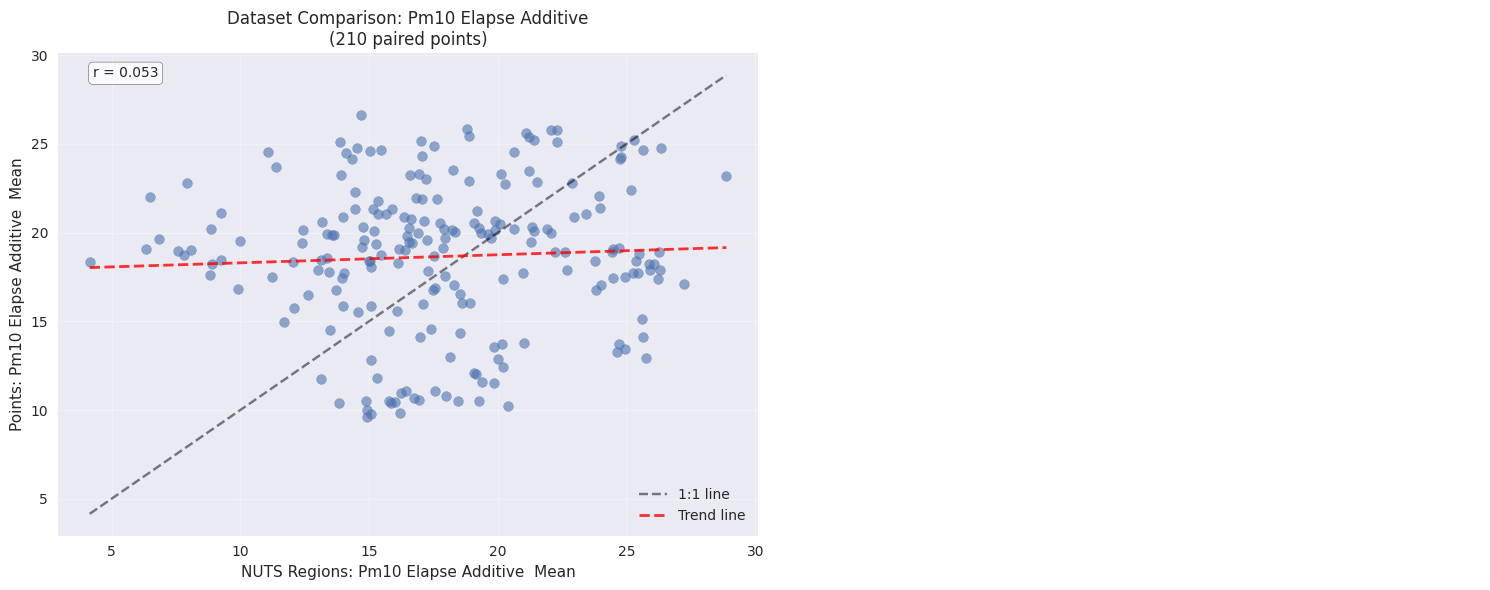

      📈 NUTS: mean=18.726, std=5.429, n=1037
      📍 Points: mean=18.654, std=4.192, n=210
      🧪 T-test: t=0.180, p=0.857
          ➡️ No significant difference between datasets (p ≥ 0.05)

   🔍 Analyzing Pm10 Mean 2010 Cfadv...


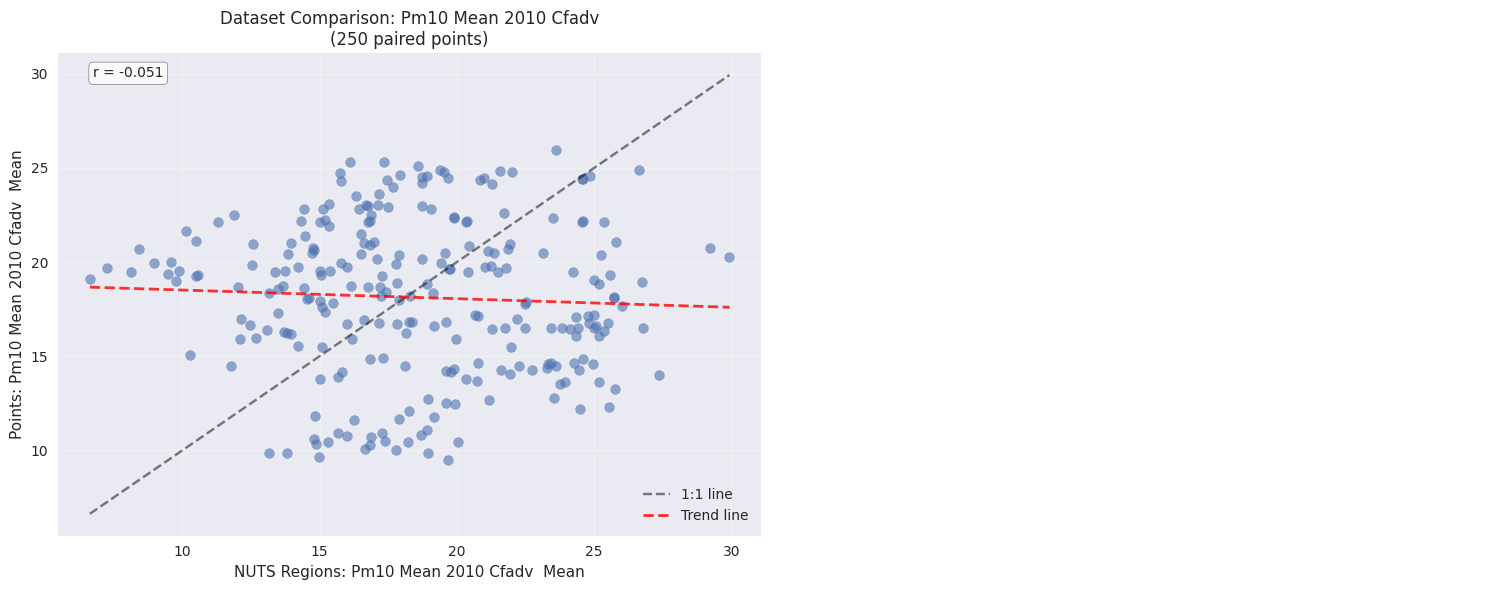

      📈 NUTS: mean=18.705, std=4.901, n=1250
      📍 Points: mean=18.121, std=4.070, n=250
      🧪 T-test: t=1.767, p=0.077
          ➡️ No significant difference between datasets (p ≥ 0.05)


In [12]:
# Between-dataset comparisons: Same variable between NUTS and Points
if nuts_results_df is not None and points_results_df is not None:
    print("\n🔄 Creating between-dataset comparisons (NUTS vs Points)...")
    
    # Find common variables
    nuts_vars = get_variable_base_names(nuts_results_df)
    points_vars = get_variable_base_names(points_results_df)
    common_vars = list(set(nuts_vars) & set(points_vars))
    
    if common_vars:
        print(f"   📊 Comparing {len(common_vars)} variables between datasets")
        
        for var in common_vars:
            print(f"\n   🔍 Analyzing {var.replace('_', ' ').title()}...")
            
            # Compare different statistics
            available_stats = []
            for stat in ['_mean', '_median', '_max']:
                if f"{var}{stat}" in nuts_results_df.columns and f"{var}{stat}" in points_results_df.columns:
                    available_stats.append(stat)
            
            if available_stats:
                # Use the first available statistic
                stat = available_stats[0]
                
                fig = create_scatter_plot(
                    nuts_results_df, points_results_df, 
                    var, var, stat=stat,
                    title_prefix='',
                    dataset1_name='NUTS Regions',
                    dataset2_name='Points',
                    comparison_type='between'
                )
                plt.show()
                
                # Show summary statistics
                nuts_col = f"{var}{stat}"
                points_col = f"{var}{stat}"
                
                nuts_data = nuts_results_df[nuts_col].dropna()
                points_data = points_results_df[points_col].dropna()
                
                if len(nuts_data) > 0 and len(points_data) > 0:
                    print(f"      📈 NUTS: mean={nuts_data.mean():.3f}, std={nuts_data.std():.3f}, n={len(nuts_data)}")
                    print(f"      📍 Points: mean={points_data.mean():.3f}, std={points_data.std():.3f}, n={len(points_data)}")
                    
                    # Statistical test if both have enough data
                    if len(nuts_data) > 5 and len(points_data) > 5:
                        from scipy import stats
                        try:
                            t_stat, p_value = stats.ttest_ind(nuts_data, points_data)
                            print(f"      🧪 T-test: t={t_stat:.3f}, p={p_value:.3f}")
                            if p_value < 0.05:
                                print(f"          ➡️ Significant difference between datasets (p < 0.05)")
                            else:
                                print(f"          ➡️ No significant difference between datasets (p ≥ 0.05)")
                        except Exception as e:
                            print(f"      ⚠️ Could not perform statistical test: {e}")
            else:
                print(f"      ⚠️ No matching statistics found for {var}")
    else:
        print("   ⚠️ No common variables found between datasets")
else:
    print("\n⚠️ Need both NUTS and Points results for between-dataset comparisons")


🔗 Creating correlation analysis...
   📊 NUTS Regions Correlation Analysis:


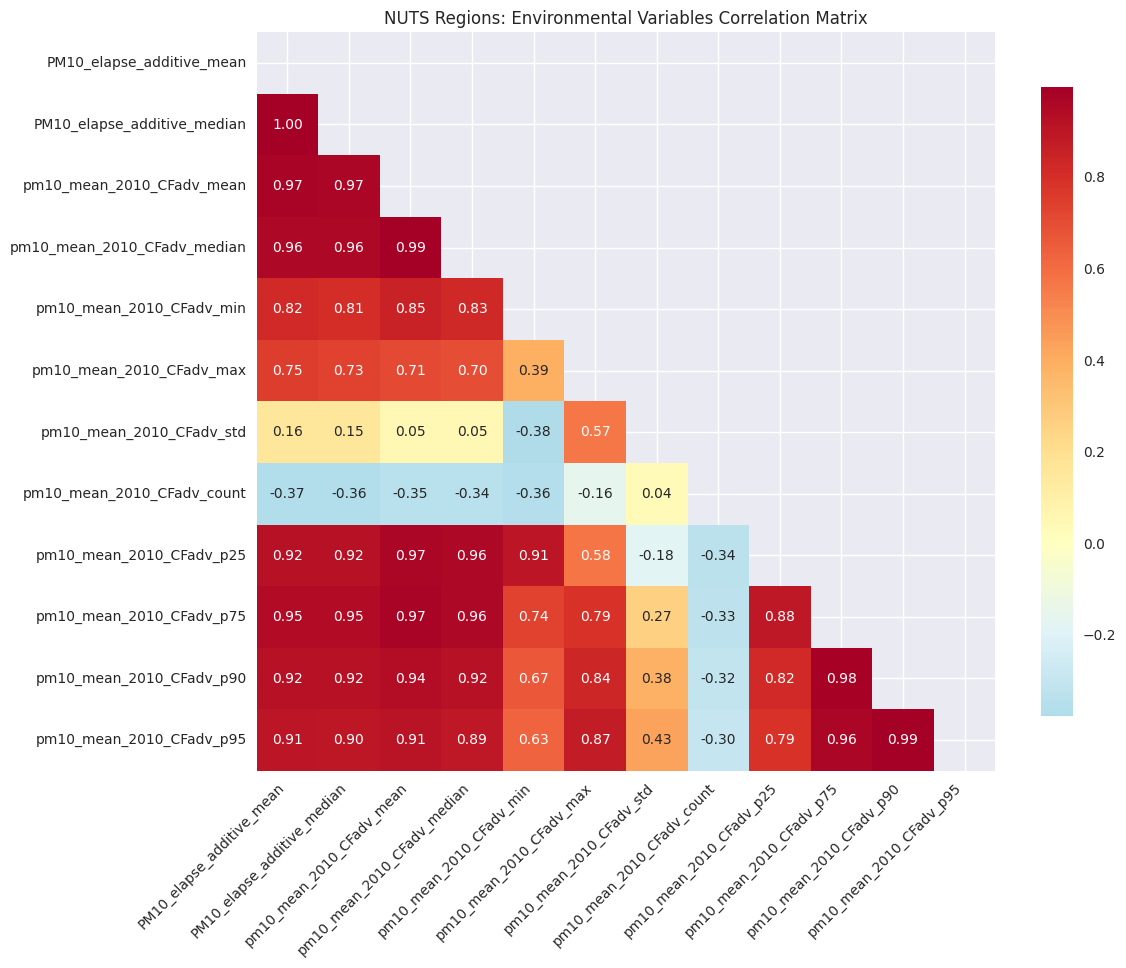

      🔥 Strongest correlations:
         PM10_elapse_additive_mean ↔ PM10_elapse_additive_median: r = 0.996
         pm10_mean_2010_CFadv_p90 ↔ pm10_mean_2010_CFadv_p95: r = 0.992
         pm10_mean_2010_CFadv_mean ↔ pm10_mean_2010_CFadv_median: r = 0.992
         pm10_mean_2010_CFadv_p75 ↔ pm10_mean_2010_CFadv_p90: r = 0.982
         pm10_mean_2010_CFadv_mean ↔ pm10_mean_2010_CFadv_p75: r = 0.971

   📍 Points Correlation Analysis:


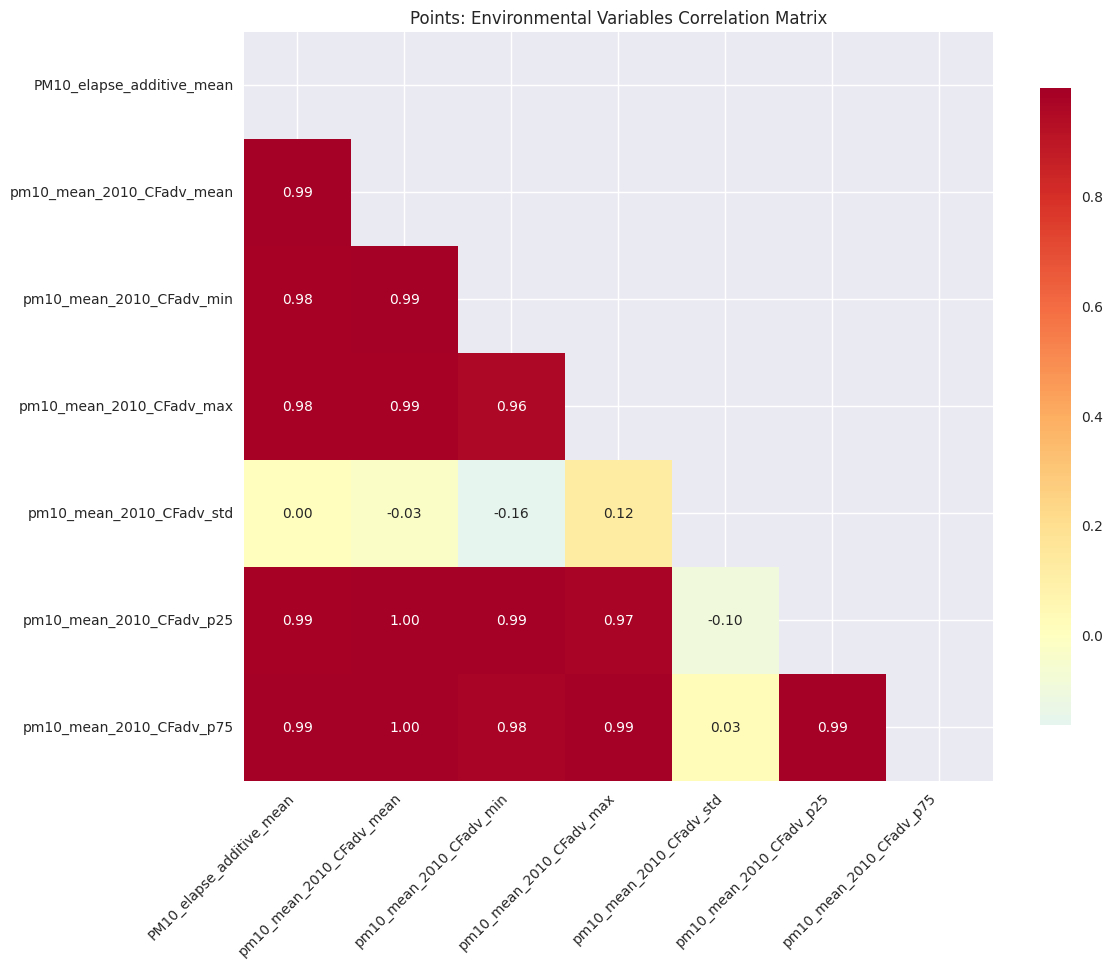

      🔥 Strongest correlations:
         pm10_mean_2010_CFadv_mean ↔ pm10_mean_2010_CFadv_p25: r = 0.997
         pm10_mean_2010_CFadv_mean ↔ pm10_mean_2010_CFadv_p75: r = 0.997
         PM10_elapse_additive_mean ↔ pm10_mean_2010_CFadv_mean: r = 0.992
         pm10_mean_2010_CFadv_min ↔ pm10_mean_2010_CFadv_p25: r = 0.991
         PM10_elapse_additive_mean ↔ pm10_mean_2010_CFadv_p75: r = 0.990


In [13]:
# Advanced correlation analysis
def create_correlation_matrix(df, title_prefix=''):
    """Create correlation matrix for environmental variables"""
    if df is None:
        return None
    
    # Get environmental variable columns
    env_cols = [col for col in df.columns if any(stat in col for stat in ['_mean', '_median']) and 
                df[col].dtype.kind in 'fi']
    
    if len(env_cols) < 2:
        return None
    
    # Calculate correlation matrix
    corr_data = df[env_cols].corr()
    
    # Create heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_data, dtype=bool))  # Mask upper triangle
    
    sns.heatmap(corr_data, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    
    plt.title(f'{title_prefix}Environmental Variables Correlation Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    return corr_data

print("\n🔗 Creating correlation analysis...")

# Correlation analysis for NUTS data
if nuts_results_df is not None:
    print("   📊 NUTS Regions Correlation Analysis:")
    nuts_corr = create_correlation_matrix(nuts_results_df, 'NUTS Regions: ')
    if nuts_corr is not None:
        plt.show()
        
        # Find strongest correlations
        nuts_corr_flat = nuts_corr.where(np.triu(np.ones(nuts_corr.shape), k=1).astype(bool))
        strong_corr = nuts_corr_flat.stack().sort_values(key=abs, ascending=False)
        
        if len(strong_corr) > 0:
            print("      🔥 Strongest correlations:")
            for (var1, var2), corr_val in strong_corr.head(5).items():
                print(f"         {var1} ↔ {var2}: r = {corr_val:.3f}")
    else:
        print("      ⚠️ Insufficient data for correlation analysis")

# Correlation analysis for Points data
if points_results_df is not None:
    print("\n   📍 Points Correlation Analysis:")
    points_corr = create_correlation_matrix(points_results_df, 'Points: ')
    if points_corr is not None:
        plt.show()
        
        # Find strongest correlations
        points_corr_flat = points_corr.where(np.triu(np.ones(points_corr.shape), k=1).astype(bool))
        strong_corr = points_corr_flat.stack().sort_values(key=abs, ascending=False)
        
        if len(strong_corr) > 0:
            print("      🔥 Strongest correlations:")
            for (var1, var2), corr_val in strong_corr.head(5).items():
                print(f"         {var1} ↔ {var2}: r = {corr_val:.3f}")
    else:
        print("      ⚠️ Insufficient data for correlation analysis")

In [14]:
# Interactive scatter plot widget
def create_interactive_scatter_widget():
    """Create interactive widgets for custom scatter plot comparisons"""
    
    # Get available variables
    all_vars = []
    if nuts_results_df is not None:
        all_vars.extend(get_variable_base_names(nuts_results_df))
    if points_results_df is not None:
        all_vars.extend(get_variable_base_names(points_results_df))
    
    unique_vars = sorted(list(set(all_vars)))
    
    if len(unique_vars) < 2:
        print("⚠️ Need at least 2 variables for interactive scatter plots")
        return
    
    # Create widgets
    var1_dropdown = widgets.Dropdown(
        options=unique_vars,
        value=unique_vars[0],
        description='X Variable:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    var2_dropdown = widgets.Dropdown(
        options=unique_vars,
        value=unique_vars[1] if len(unique_vars) > 1 else unique_vars[0],
        description='Y Variable:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    stat_dropdown = widgets.Dropdown(
        options=[('Mean', '_mean'), ('Median', '_median'), ('Maximum', '_max'), ('Minimum', '_min')],
        value='_mean',
        description='Statistic:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )
    
    comparison_dropdown = widgets.Dropdown(
        options=[('Within Dataset', 'within'), ('Between Datasets', 'between')],
        value='within',
        description='Comparison:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='250px')
    )
    
    # Output widget
    plot_output = widgets.Output()
    
    # Update function
    def update_scatter_plot(*args):
        with plot_output:
            clear_output(wait=True)
            
            var1 = var1_dropdown.value
            var2 = var2_dropdown.value
            stat = stat_dropdown.value
            comp_type = comparison_dropdown.value
            
            print(f"🎯 Creating scatter plot: {var1} vs {var2} ({stat.replace('_', ' ').title()})")
            
            if comp_type == 'between' and var1 != var2:
                print("   ℹ️ For between-dataset comparison, using same variable for both axes")
                var2 = var1
            
            try:
                fig = create_scatter_plot(
                    nuts_results_df, points_results_df,
                    var1, var2, stat=stat,
                    title_prefix='Interactive: ',
                    dataset1_name='NUTS Regions',
                    dataset2_name='Points',
                    comparison_type=comp_type
                )
                plt.show()
            except Exception as e:
                print(f"❌ Error creating plot: {e}")
    
    # Attach observers
    var1_dropdown.observe(update_scatter_plot, names='value')
    var2_dropdown.observe(update_scatter_plot, names='value')
    stat_dropdown.observe(update_scatter_plot, names='value')
    comparison_dropdown.observe(update_scatter_plot, names='value')
    
    # Layout widgets
    controls_row1 = widgets.HBox([var1_dropdown, var2_dropdown])
    controls_row2 = widgets.HBox([stat_dropdown, comparison_dropdown])
    controls = widgets.VBox([controls_row1, controls_row2])
    
    print("🎛️ Interactive Scatter Plot Controls:")
    display(controls)
    display(plot_output)
    
    # Create initial plot
    update_scatter_plot()

# Create interactive widget if we have data
if nuts_results_df is not None or points_results_df is not None:
    print("\n🎮 Creating interactive scatter plot widget...")
    create_interactive_scatter_widget()
else:
    print("\n⚠️ No data available for interactive scatter plots")


🎮 Creating interactive scatter plot widget...
🎛️ Interactive Scatter Plot Controls:


Output()

In [ ]:
# Interactive map creation with variable selection
def create_interactive_map(selected_var, geometry_type='both'):
    """Create an interactive map for the selected environmental variable"""
    m = folium.Map(location=[54, 15], zoom_start=4)
    
    # Add NUTS regions with choropleth if available
    if nuts_results_df is not None and os.path.exists(NUTS_FILE) and geometry_type in ['both', 'nuts']:
        try:
            nuts_gdf = gpd.read_file(NUTS_FILE)
            
            # Find ID column for merging
            id_col = 'id' if 'id' in nuts_results_df.columns else nuts_results_df.columns[0]
            nuts_id_col = 'NUTS_ID' if 'NUTS_ID' in nuts_gdf.columns else nuts_gdf.columns[0]
            
            nuts_merged = nuts_gdf.merge(nuts_results_df, left_on=nuts_id_col, right_on=id_col, how='inner')
            
            if selected_var in nuts_merged.columns:
                # Filter out invalid values
                nuts_merged_clean = nuts_merged[nuts_merged[selected_var].notna() & (nuts_merged[selected_var] >= 0)]
                
                if len(nuts_merged_clean) > 0:
                    # Add choropleth layer
                    folium.Choropleth(
                        geo_data=nuts_merged_clean,
                        name='NUTS Regions',
                        data=nuts_merged_clean,
                        columns=[nuts_id_col, selected_var],
                        key_on=f'feature.properties.{nuts_id_col}',
                        fill_color='YlOrRd',
                        fill_opacity=0.7,
                        line_opacity=0.2,
                        legend_name=selected_var.replace('_', ' ').title(),
                        nan_fill_color='lightgray',
                        nan_fill_opacity=0.3
                    ).add_to(m)
                    
                    print(f"✅ Added {len(nuts_merged_clean)} NUTS regions to map")
                else:
                    print(f"⚠️ No valid data for {selected_var} in NUTS regions")
        except Exception as e:
            print(f"⚠️ Could not add NUTS regions to map: {e}")
    
    # Add points if available
    if points_results_df is not None and os.path.exists(POINTS_FILE) and geometry_type in ['both', 'points']:
        try:
            points_gdf = gpd.read_file(POINTS_FILE)
            
            if selected_var in points_results_df.columns:
                valid_points = 0
                for idx, row in points_results_df.iterrows():
                    if idx < len(points_gdf) and pd.notna(row[selected_var]) and row[selected_var] >= 0:
                        geom = points_gdf.iloc[idx].geometry
                        value = row[selected_var]
                        
                        # Color points based on value quartiles
                        quartiles = points_results_df[selected_var].quantile([0.25, 0.5, 0.75])
                        if value <= quartiles[0.25]:
                            color = 'green'
                        elif value <= quartiles[0.5]:
                            color = 'yellow'
                        elif value <= quartiles[0.75]:
                            color = 'orange'
                        else:
                            color = 'red'
                        
                        folium.CircleMarker(
                            location=[geom.y, geom.x],
                            radius=6,
                            color=color,
                            fill=True,
                            fillColor=color,
                            fillOpacity=0.8,
                            popup=f"{selected_var.replace('_', ' ').title()}: {value:.2f}",
                            tooltip=f"Point {idx}: {value:.2f}"
                        ).add_to(m)
                        valid_points += 1
                
                print(f"✅ Added {valid_points} points to map")
        except Exception as e:
            print(f"⚠️ Could not add points to map: {e}")
    
    # Add layer control
    folium.LayerControl().add_to(m)
    return m

# Create interactive controls
if nuts_results_df is not None or points_results_df is not None:
    # Get all available environmental variables
    all_vars = []
    if nuts_results_df is not None:
        all_vars.extend([col for col in nuts_results_df.columns if any(stat in col for stat in ['_mean', '_median', '_max', '_min', '_std'])])
    if points_results_df is not None:
        all_vars.extend([col for col in points_results_df.columns if any(stat in col for stat in ['_mean', '_median', '_max', '_min', '_std'])])
    
    # Remove duplicates and sort
    unique_vars = sorted(list(set(all_vars)))
    
    if unique_vars:
        print(f"🎛️ Interactive Map Controls")
        print(f"📊 Available variables: {len(unique_vars)}")
        
        # Create dropdown widgets
        var_dropdown = widgets.Dropdown(
            options=unique_vars,
            value=unique_vars[0],
            description='Variable:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
        
        geom_dropdown = widgets.Dropdown(
            options=[('Both', 'both'), ('NUTS Regions Only', 'nuts'), ('Points Only', 'points')],
            value='both',
            description='Geometry:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px')
        )
        
        # Output widget for the map
        map_output = widgets.Output()
        
        # Function to update map when controls change
        def update_map(*args):
            with map_output:
                clear_output(wait=True)
                print(f"🗺️ Creating map for: {var_dropdown.value} ({geom_dropdown.value})")
                m = create_interactive_map(var_dropdown.value, geom_dropdown.value)
                display(m)
        
        # Attach observers
        var_dropdown.observe(update_map, names='value')
        geom_dropdown.observe(update_map, names='value')
        
        # Display controls and initial map
        controls = widgets.HBox([var_dropdown, geom_dropdown])
        display(controls)
        display(map_output)
        
        # Create initial map
        update_map()
        
    else:
        print("⚠️ No environmental variables found for mapping")
else:
    print("⚠️ No results available for mapping")


SyntaxError: unterminated string literal (detected at line 149) (3115150280.py, line 149)

## 7. Create an Interactive Map

Finally, let's create an interactive map showing both NUTS regions and points, colored by one of our environmental variables.

## Conclusion

In this notebook, we've demonstrated how to:

1. **Load and inspect environmental data** - Understanding our input rasters and boundary geometries
2. **Extract comprehensive statistics** - Getting mean, median, percentiles, and other statistics for NUTS regions
3. **Process point locations** - Extracting data with buffers around monitoring stations
4. **Create various visualizations** - Distribution plots, comparisons, and box plots
5. **Generate interactive maps** - Spatial visualization with choropleth maps and point markers

### Key Takeaways:

- **Flexible Configuration**: EnvXtract allows detailed configuration of extraction parameters
- **Multiple Geometry Types**: Support for both polygon (NUTS) and point geometries
- **Comprehensive Statistics**: Beyond simple means, we can extract percentiles, standard deviations, and more
- **Batch Processing**: Multiple raster files can be processed simultaneously
- **Quality Control**: Built-in coverage requirements and data validation

### Next Steps:

- **Temporal Analysis**: Process time series of environmental data
- **Multi-pollutant Studies**: Combine different environmental variables
- **Exposure Assessment**: Link extracted values to health or demographic data
- **Custom Statistics**: Implement domain-specific statistical measures

### Workflow Adaptability:

This workflow can be easily adapted for:
- Different environmental variables (temperature, precipitation, etc.)
- Various administrative levels (NUTS1, NUTS2, municipalities)
- Different geographic regions
- Custom point networks (air quality stations, weather stations, etc.)

**Happy analyzing! 🌍📊**

## 8. Multi-Raster Source Comparisons

Now let's implement intelligent comparisons of the same variables extracted from different raster sources. This is particularly useful for:
- Comparing PM10 measurements from different satellite sensors
- Validating model predictions against observations
- Assessing temporal changes (same variable, different years)
- Cross-platform environmental data validation

In [ ]:
# Multi-raster comparison functionality
import re
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit

def detect_raster_sources_from_columns(df):
    """Intelligently detect different raster sources from column names"""
    if df is None:
        return {}
    
    # Pattern to extract raster source names from column names
    # Assumes format: source_name_variable_statistic (e.g., "modis_PM10_mean", "sentinel_PM10_mean")
    sources = {}
    
    for col in df.columns:
        # Skip non-environmental columns
        if not any(stat in col for stat in ['_mean', '_median', '_max', '_min', '_std']):
            continue
            
        # Extract parts: source_variable_statistic
        parts = col.split('_')
        if len(parts) >= 3:
            # Try different patterns
            # Pattern 1: source_variable_statistic (e.g., modis_PM10_mean)
            if len(parts) == 3:
                source, variable, statistic = parts
                
            # Pattern 2: source_subtype_variable_statistic (e.g., modis_aqua_PM10_mean)
            elif len(parts) == 4:
                source = f"{parts[0]}_{parts[1]}"
                variable, statistic = parts[2], parts[3]
                
            # Pattern 3: More complex patterns
            else:
                # Take first part as source, last as statistic, middle as variable
                source = parts[0]
                variable = '_'.join(parts[1:-1])
                statistic = parts[-1]
            
            if source not in sources:
                sources[source] = {}
            if variable not in sources[source]:
                sources[source][variable] = []
            
            sources[source][variable].append({
                'column': col,
                'statistic': statistic
            })
    
    return sources

def find_common_variables_across_sources(sources_dict):
    """Find variables that exist in multiple raster sources"""
    if len(sources_dict) < 2:
        return []
        
    # Get all variables from all sources
    all_variables = {}
    for source, variables in sources_dict.items():
        for variable in variables.keys():
            if variable not in all_variables:
                all_variables[variable] = []
            all_variables[variable].append(source)
    
    # Find variables that appear in multiple sources
    common_variables = {}
    for variable, sources_list in all_variables.items():
        if len(sources_list) >= 2:
            common_variables[variable] = sources_list
    
    return common_variables

def create_multi_source_scatter_plot(df, variable, sources, statistic='_mean', 
                                   geometry_type='NUTS', regression_type='linear'):
    """Create scatter plots comparing the same variable from different raster sources"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Get source pairs for comparison
    source_pairs = [(sources[i], sources[j]) for i in range(len(sources)) 
                    for j in range(i+1, len(sources))]
    
    if not source_pairs:
        print(f"Need at least 2 sources for comparison. Found: {len(sources)}")
        return fig
    
    # Take first pair for main comparison
    source1, source2 = source_pairs[0]
    
    # Construct column names
    col1 = f"{source1}_{variable}{statistic}"
    col2 = f"{source2}_{variable}{statistic}"
    
    # Check if columns exist
    if col1 not in df.columns or col2 not in df.columns:
        print(f"Columns not found: {col1}, {col2}")
        print(f"Available columns: {list(df.columns)}")
        return fig
    
    # Get valid data pairs
    valid_mask = df[col1].notna() & df[col2].notna() & (df[col1] >= 0) & (df[col2] >= 0)
    x_data = df.loc[valid_mask, col1]
    y_data = df.loc[valid_mask, col2]
    
    if len(x_data) == 0:
        axes[0].text(0.5, 0.5, 'No valid data pairs', transform=axes[0].transAxes, 
                    ha='center', va='center', fontsize=14)
        axes[1].text(0.5, 0.5, 'No valid data pairs', transform=axes[1].transAxes, 
                    ha='center', va='center', fontsize=14)
        return fig
    
    # Main scatter plot
    axes[0].scatter(x_data, y_data, alpha=0.6, s=50, color='steelblue', edgecolors='navy', linewidth=0.5)
    
    # Calculate and plot regression line
    if len(x_data) >= 3:
        # Linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
        
        # Generate regression line
        x_line = np.linspace(x_data.min(), x_data.max(), 100)
        y_line = slope * x_line + intercept
        
        # Plot regression line
        axes[0].plot(x_line, y_line, 'red', linewidth=2, alpha=0.8, 
                    label=f'y = {slope:.3f}x + {intercept:.3f}')
        
        # Add 1:1 line for reference
        min_val = min(x_data.min(), y_data.min())
        max_val = max(x_data.max(), y_data.max())
        axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, 
                    linewidth=1, label='1:1 line')
        
        # Add statistics text box
        stats_text = f'R² = {r_value**2:.3f}\n'
        stats_text += f'R = {r_value:.3f}\n'
        stats_text += f'RMSE = {np.sqrt(np.mean((y_data - (slope * x_data + intercept))**2)):.3f}\n'
        stats_text += f'p = {p_value:.2e}\n'
        stats_text += f'n = {len(x_data)}'
        
        axes[0].text(0.05, 0.95, stats_text, transform=axes[0].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                    facecolor='white', alpha=0.8), fontsize=10)
        
        axes[0].legend(loc='lower right')
    
    # Formatting
    axes[0].set_xlabel(f'{source1.replace("_", " ").title()}: {variable} {statistic.replace("_", " ").title()}')
    axes[0].set_ylabel(f'{source2.replace("_", " ").title()}: {variable} {statistic.replace("_", " ").title()}')
    axes[0].set_title(f'{variable} Comparison: {source1.replace("_", " ").title()} vs {source2.replace("_", " ").title()}\n({geometry_type} geometries)')
    axes[0].grid(True, alpha=0.3)
    
    # Residuals plot
    if len(x_data) >= 3:
        predicted = slope * x_data + intercept
        residuals = y_data - predicted
        
        axes[1].scatter(predicted, residuals, alpha=0.6, s=50, color='orange', edgecolors='darkorange')
        axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
        
        axes[1].set_xlabel('Predicted Values')
        axes[1].set_ylabel('Residuals')
        axes[1].set_title('Residual Plot')
        axes[1].grid(True, alpha=0.3)
        
        # Add residual statistics
        residual_std = np.std(residuals)
        axes[1].text(0.05, 0.95, f'Residual Std = {residual_std:.3f}', 
                    transform=axes[1].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig

def create_multi_source_comparison_matrix(df, variable, sources, statistic='_mean', geometry_type='NUTS'):
    """Create a matrix of scatter plots comparing all source pairs"""
    n_sources = len(sources)
    if n_sources < 2:
        print(f"Need at least 2 sources for comparison matrix. Found: {n_sources}")
        return None
    
    # Create subplot matrix
    fig, axes = plt.subplots(n_sources, n_sources, figsize=(4*n_sources, 4*n_sources))
    if n_sources == 2:
        axes = axes.reshape(2, 2)
    
    for i, source1 in enumerate(sources):
        for j, source2 in enumerate(sources):
            ax = axes[i, j] if n_sources > 2 else axes[i][j]
            
            if i == j:
                # Diagonal: histogram of single source
                col = f"{source1}_{variable}{statistic}"
                if col in df.columns:
                    valid_data = df[df[col].notna() & (df[col] >= 0)][col]
                    if len(valid_data) > 0:
                        ax.hist(valid_data, bins=20, alpha=0.7, color='skyblue', edgecolor='navy')
                        ax.set_title(f'{source1.replace("_", " ").title()}\n(n={len(valid_data)})')
                        ax.set_ylabel('Frequency')
                    else:
                        ax.text(0.5, 0.5, 'No valid data', transform=ax.transAxes, ha='center')
                else:
                    ax.text(0.5, 0.5, f'Column {col}\nnot found', transform=ax.transAxes, ha='center')
            
            elif i < j:
                # Upper triangle: scatter plots
                col1 = f"{source1}_{variable}{statistic}"
                col2 = f"{source2}_{variable}{statistic}"
                
                if col1 in df.columns and col2 in df.columns:
                    valid_mask = df[col1].notna() & df[col2].notna() & (df[col1] >= 0) & (df[col2] >= 0)
                    x_data = df.loc[valid_mask, col1]
                    y_data = df.loc[valid_mask, col2]
                    
                    if len(x_data) >= 3:
                        ax.scatter(x_data, y_data, alpha=0.6, s=30)
                        
                        # Add regression line and R²
                        slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)
                        x_line = np.linspace(x_data.min(), x_data.max(), 100)
                        y_line = slope * x_line + intercept
                        ax.plot(x_line, y_line, 'red', linewidth=1.5, alpha=0.8)
                        
                        # Add 1:1 line
                        min_val = min(x_data.min(), y_data.min())
                        max_val = max(x_data.max(), y_data.max())
                        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
                        
                        ax.text(0.05, 0.95, f'R² = {r_value**2:.3f}', transform=ax.transAxes, 
                               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), fontsize=9)
                        
                        ax.set_title(f'{source1.replace("_", " ").title()} vs {source2.replace("_", " ").title()}')
                    else:
                        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(x_data)})', 
                               transform=ax.transAxes, ha='center')
                else:
                    ax.text(0.5, 0.5, 'Columns not found', transform=ax.transAxes, ha='center')
                
                ax.grid(True, alpha=0.3)
            
            else:
                # Lower triangle: correlation values or statistics
                col1 = f"{source1}_{variable}{statistic}"
                col2 = f"{source2}_{variable}{statistic}"
                
                if col1 in df.columns and col2 in df.columns:
                    valid_mask = df[col1].notna() & df[col2].notna() & (df[col1] >= 0) & (df[col2] >= 0)
                    x_data = df.loc[valid_mask, col1]
                    y_data = df.loc[valid_mask, col2]
                    
                    if len(x_data) >= 3:
                        corr = np.corrcoef(x_data, y_data)[0, 1]
                        rmse = np.sqrt(np.mean((x_data - y_data)**2))
                        mae = np.mean(np.abs(x_data - y_data))
                        
                        stats_text = f'Correlation:\n{corr:.3f}\n\n'
                        stats_text += f'RMSE:\n{rmse:.3f}\n\n'
                        stats_text += f'MAE:\n{mae:.3f}\n\n'
                        stats_text += f'N: {len(x_data)}'
                        
                        ax.text(0.5, 0.5, stats_text, transform=ax.transAxes, 
                               ha='center', va='center', fontsize=11,
                               bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
                    else:
                        ax.text(0.5, 0.5, f'Insufficient data\n(n={len(x_data)})', 
                               transform=ax.transAxes, ha='center')
                else:
                    ax.text(0.5, 0.5, 'Columns not found', transform=ax.transAxes, ha='center')
                
                ax.set_xticks([])
                ax.set_yticks([])
    
    plt.suptitle(f'{variable.replace("_", " ").title()} Multi-Source Comparison Matrix\n({geometry_type} geometries, {statistic.replace("_", " ").title()} values)', 
                 fontsize=16, y=0.98)
    plt.tight_layout()
    return fig

print("✅ Multi-raster comparison functions defined successfully!")

In [ ]:
# Detect raster sources and find comparable variables
print("🔍 Detecting raster sources and comparable variables...")

# Analyze NUTS data for multi-source comparisons
if nuts_results_df is not None:
    print("\n📊 NUTS Regions Multi-Source Analysis:")
    nuts_sources = detect_raster_sources_from_columns(nuts_results_df)
    nuts_common_vars = find_common_variables_across_sources(nuts_sources)
    
    print(f"   Found {len(nuts_sources)} potential sources:")
    for source, variables in nuts_sources.items():
        print(f"      - {source.replace('_', ' ').title()}: {len(variables)} variables")
    
    if nuts_common_vars:
        print(f"   🎯 Variables available in multiple sources:")
        for variable, sources_list in nuts_common_vars.items():
            print(f"      - {variable.replace('_', ' ').title()}: {len(sources_list)} sources ({', '.join([s.replace('_', ' ').title() for s in sources_list])})")
    else:
        print("      ⚠️ No variables found in multiple sources for NUTS data")
        print("      💡 This might happen if raster files don't have distinguishable source names")
        print("      💡 Expected column format: 'source_variable_statistic' (e.g., 'modis_PM10_mean')")
else:
    nuts_sources = {}
    nuts_common_vars = {}

# Analyze Points data for multi-source comparisons
if points_results_df is not None:
    print("\n📍 Points Multi-Source Analysis:")
    points_sources = detect_raster_sources_from_columns(points_results_df)
    points_common_vars = find_common_variables_across_sources(points_sources)
    
    print(f"   Found {len(points_sources)} potential sources:")
    for source, variables in points_sources.items():
        print(f"      - {source.replace('_', ' ').title()}: {len(variables)} variables")
    
    if points_common_vars:
        print(f"   🎯 Variables available in multiple sources:")
        for variable, sources_list in points_common_vars.items():
            print(f"      - {variable.replace('_', ' ').title()}: {len(sources_list)} sources ({', '.join([s.replace('_', ' ').title() for s in sources_list])})")
    else:
        print("      ⚠️ No variables found in multiple sources for Points data")
else:
    points_sources = {}
    points_common_vars = {}

# Summary
if nuts_common_vars or points_common_vars:
    print("\n✅ Multi-source comparisons available!")
    print("   📈 Will create scatter plots with regression equations and R² values")
else:
    print("\n⚠️ No multi-source comparisons detected")
    print("   💡 To enable multi-source comparisons, ensure raster filenames contain source identifiers")
    print("   📝 Example: 'modis_PM10.tif' and 'sentinel_PM10.tif' would be detected as different sources")

In [ ]:
# Create multi-source comparisons for NUTS regions
if nuts_common_vars:
    print("\n🏛️ Creating Multi-Source Comparisons for NUTS Regions...")
    
    for variable, sources_list in list(nuts_common_vars.items())[:3]:  # Limit to first 3 variables
        print(f"\n   📊 Analyzing {variable.replace('_', ' ').title()}...")
        
        # Create pairwise comparison
        if len(sources_list) >= 2:
            fig = create_multi_source_scatter_plot(
                nuts_results_df, variable, sources_list[:2],  # Take first 2 sources
                statistic='_mean', geometry_type='NUTS Regions'
            )
            plt.show()
            
            # If there are more than 2 sources, create comparison matrix
            if len(sources_list) > 2:
                print(f"   📈 Creating comparison matrix for all {len(sources_list)} sources...")
                fig_matrix = create_multi_source_comparison_matrix(
                    nuts_results_df, variable, sources_list,
                    statistic='_mean', geometry_type='NUTS Regions'
                )
                if fig_matrix:
                    plt.show()
else:
    print("\n⚠️ No multi-source variables available for NUTS regions")
    
    # Provide helpful suggestions
    if nuts_sources:
        print("   💡 Available sources and their variables:")
        for source, variables in nuts_sources.items():
            var_list = ', '.join([v.replace('_', ' ').title() for v in variables.keys()])
            print(f"      - {source.replace('_', ' ').title()}: {var_list}")
        print("   💡 To enable comparisons, you need the same variable from different sources")

In [ ]:
# Create multi-source comparisons for Points
if points_common_vars:
    print("\n📍 Creating Multi-Source Comparisons for Points...")
    
    for variable, sources_list in list(points_common_vars.items())[:3]:  # Limit to first 3 variables
        print(f"\n   📊 Analyzing {variable.replace('_', ' ').title()}...")
        
        # Create pairwise comparison
        if len(sources_list) >= 2:
            fig = create_multi_source_scatter_plot(
                points_results_df, variable, sources_list[:2],  # Take first 2 sources
                statistic='_mean', geometry_type='Points'
            )
            plt.show()
            
            # If there are more than 2 sources, create comparison matrix
            if len(sources_list) > 2:
                print(f"   📈 Creating comparison matrix for all {len(sources_list)} sources...")
                fig_matrix = create_multi_source_comparison_matrix(
                    points_results_df, variable, sources_list,
                    statistic='_mean', geometry_type='Points'
                )
                if fig_matrix:
                    plt.show()
else:
    print("\n⚠️ No multi-source variables available for Points")
    
    # Provide helpful suggestions
    if points_sources:
        print("   💡 Available sources and their variables:")
        for source, variables in points_sources.items():
            var_list = ', '.join([v.replace('_', ' ').title() for v in variables.keys()])
            print(f"      - {source.replace('_', ' ').title()}: {var_list}")
        print("   💡 To enable comparisons, you need the same variable from different sources")

In [ ]:
# Interactive Multi-Source Comparison Widget
def create_multi_source_interactive_widget():
    """Create interactive widget for multi-source comparisons"""
    
    # Combine all available multi-source variables
    all_multi_vars = {}
    datasets_available = []
    
    if nuts_common_vars:
        all_multi_vars.update(nuts_common_vars)
        datasets_available.append('NUTS Regions')
    
    if points_common_vars:
        # Merge with existing, prioritizing variables with more sources
        for var, sources in points_common_vars.items():
            if var in all_multi_vars:
                # Combine sources from both datasets
                combined_sources = list(set(all_multi_vars[var] + sources))
                all_multi_vars[var] = combined_sources
            else:
                all_multi_vars[var] = sources
        datasets_available.append('Points')
    
    if not all_multi_vars:
        print("⚠️ No multi-source variables available for interactive comparison")
        return
    
    # Create widgets
    variable_options = list(all_multi_vars.keys())
    dataset_options = datasets_available if len(datasets_available) > 1 else datasets_available + ['Both']
    
    variable_dropdown = widgets.Dropdown(
        options=variable_options,
        value=variable_options[0],
        description='Variable:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )
    
    dataset_dropdown = widgets.Dropdown(
        options=dataset_options,
        value=dataset_options[0],
        description='Dataset:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='250px')
    )
    
    statistic_dropdown = widgets.Dropdown(
        options=[('Mean', '_mean'), ('Median', '_median'), ('Maximum', '_max')],
        value='_mean',
        description='Statistic:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='200px')
    )
    
    plot_type_dropdown = widgets.Dropdown(
        options=[('Pairwise Comparison', 'pairwise'), ('Comparison Matrix', 'matrix')],
        value='pairwise',
        description='Plot Type:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='250px')
    )
    
    # Output widget
    multi_output = widgets.Output()
    
    # Update function
    def update_multi_source_plot(*args):
        with multi_output:
            clear_output(wait=True)
            
            variable = variable_dropdown.value
            dataset = dataset_dropdown.value
            statistic = statistic_dropdown.value
            plot_type = plot_type_dropdown.value
            
            print(f"🎯 Multi-Source Analysis: {variable.replace('_', ' ').title()}")
            print(f"   Dataset: {dataset}, Statistic: {statistic.replace('_', ' ').title()}, Plot: {plot_type.title()}")
            
            # Determine which dataframe to use
            target_df = None
            geometry_type = dataset
            
            if dataset == 'NUTS Regions' and nuts_results_df is not None:
                target_df = nuts_results_df
                available_sources = nuts_common_vars.get(variable, [])
            elif dataset == 'Points' and points_results_df is not None:
                target_df = points_results_df
                available_sources = points_common_vars.get(variable, [])
            elif dataset == 'Both':
                # For 'Both', prioritize NUTS if available
                if nuts_results_df is not None and variable in nuts_common_vars:
                    target_df = nuts_results_df
                    available_sources = nuts_common_vars.get(variable, [])
                    geometry_type = 'NUTS Regions'
                elif points_results_df is not None and variable in points_common_vars:
                    target_df = points_results_df
                    available_sources = points_common_vars.get(variable, [])
                    geometry_type = 'Points'
            
            if target_df is None or not available_sources:
                print(f"❌ No data available for {variable} in {dataset}")
                return
            
            try:
                if plot_type == 'pairwise':
                    fig = create_multi_source_scatter_plot(
                        target_df, variable, available_sources[:2],
                        statistic=statistic, geometry_type=geometry_type
                    )
                    plt.show()
                else:  # matrix
                    fig = create_multi_source_comparison_matrix(
                        target_df, variable, available_sources,
                        statistic=statistic, geometry_type=geometry_type
                    )
                    if fig:
                        plt.show()
                    else:
                        print("❌ Could not create comparison matrix")
                        
            except Exception as e:
                print(f"❌ Error creating plot: {e}")
    
    # Attach observers
    variable_dropdown.observe(update_multi_source_plot, names='value')
    dataset_dropdown.observe(update_multi_source_plot, names='value')
    statistic_dropdown.observe(update_multi_source_plot, names='value')
    plot_type_dropdown.observe(update_multi_source_plot, names='value')
    
    # Layout widgets
    controls_row1 = widgets.HBox([variable_dropdown, dataset_dropdown])
    controls_row2 = widgets.HBox([statistic_dropdown, plot_type_dropdown])
    controls = widgets.VBox([controls_row1, controls_row2])
    
    print("🎛️ Interactive Multi-Source Comparison Controls:")
    display(controls)
    display(multi_output)
    
    # Create initial plot
    update_multi_source_plot()

# Create the interactive widget if multi-source data is available
if nuts_common_vars or points_common_vars:
    print("\n🎮 Creating interactive multi-source comparison widget...")
    create_multi_source_interactive_widget()
else:
    print("\n⚠️ No multi-source data available for interactive comparisons")
    print("   💡 To enable this feature, extract data from rasters with different source names")
    print("   📝 Example raster names: 'modis_PM10_2020.tif', 'sentinel_PM10_2020.tif'")

In [ ]:
# Summary and interpretation guide for multi-source comparisons
if nuts_common_vars or points_common_vars:
    print("\n📋 Multi-Source Comparison Summary:")
    print("=" * 50)
    
    total_comparisons = 0
    
    if nuts_common_vars:
        print(f"\n🏛️ NUTS Regions:")
        for variable, sources_list in nuts_common_vars.items():
            n_pairs = len(sources_list) * (len(sources_list) - 1) // 2
            total_comparisons += n_pairs
            print(f"   - {variable.replace('_', ' ').title()}: {len(sources_list)} sources → {n_pairs} possible comparisons")
    
    if points_common_vars:
        print(f"\n📍 Points:")
        for variable, sources_list in points_common_vars.items():
            n_pairs = len(sources_list) * (len(sources_list) - 1) // 2
            total_comparisons += n_pairs
            print(f"   - {variable.replace('_', ' ').title()}: {len(sources_list)} sources → {n_pairs} possible comparisons")
    
    print(f"\n📊 Total possible pairwise comparisons: {total_comparisons}")
    
    print("\n📖 Interpretation Guide:")
    print("   🎯 R² Values:")
    print("      - R² > 0.8: Excellent agreement between sources")
    print("      - R² 0.6-0.8: Good agreement")
    print("      - R² 0.4-0.6: Moderate agreement")
    print("      - R² < 0.4: Poor agreement (investigate differences)")
    
    print("\n   📏 Regression Lines:")
    print("      - Slope ≈ 1, Intercept ≈ 0: Perfect linear relationship")
    print("      - Slope ≠ 1: Systematic scaling differences")
    print("      - Intercept ≠ 0: Systematic offset between sources")
    
    print("\n   📊 RMSE (Root Mean Square Error):")
    print("      - Lower RMSE indicates better agreement")
    print("      - Compare RMSE to the range of values for context")
    
    print("\n   📈 Residual Plots:")
    print("      - Random scatter: Good model fit")
    print("      - Patterns in residuals: Systematic differences between sources")
    
    print("\n💡 Use Cases:")
    print("   - Validate satellite retrievals against ground measurements")
    print("   - Compare different atmospheric models")
    print("   - Assess temporal consistency (same sensor, different years)")
    print("   - Cross-platform validation (e.g., MODIS vs Sentinel)")
    
else:
    print("\n📝 Guide for Enabling Multi-Source Comparisons:")
    print("=" * 50)
    print("\n1. 📁 Raster File Naming:")
    print("   - Include source identifier in filenames")
    print("   - Examples: 'modis_PM10_2020.tif', 'sentinel_PM10_2020.tif'")
    print("   - Pattern: 'source_variable_[additional_info].tif'")
    
    print("\n2. 🔧 Configuration:")
    print("   - Ensure 'use_raster_names_in_columns: true' in your extraction config")
    print("   - This creates columns like 'modis_PM10_mean', 'sentinel_PM10_mean'")
    
    print("\n3. 📊 Expected Results:")
    print("   - Scatter plots with regression equations")
    print("   - R² values and correlation statistics")
    print("   - Residual plots for model validation")
    print("   - Comparison matrices for multiple sources")
    
    print("\n4. 🎯 Best Practices:")
    print("   - Use consistent variable names across rasters")
    print("   - Ensure same spatial resolution when possible")
    print("   - Document data sources and processing methods")
    
print("\n🎉 Multi-raster source comparison analysis complete!")